In [1]:
import glob
from pathlib import Path

import numpy as np

import matplotlib.pyplot as plt
from astropy.table import Table, vstack
from astropy.io import fits
import astropy.constants as astcont
import astropy.units as u
from astropy.convolution import convolve, Gaussian1DKernel, Box1DKernel

import pysynphot

/home/tim/conda/envs/py38/lib/python3.8/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/home/tim/conda/envs/py38/lib/python3.8/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


In [2]:
def load_sky_spectrum(fitsfile, pixscale=0.6, slitwidth=5., zeropoint=48.6):
    """
    Load a Pypeit-reduced 1D sky spectrum and return wavelength in Angstroms and flux in ABmag/arcsec**2

        fitsfile: string - filename of FITS spectrum
        pixscale: float - spatial pixel scale (arcsec/pixel)
        slitwidth: float - width of the slit (arcsec)
        zeropoint: float - zeropoint for AB mag system (AB mag)
    """
    spec = Table.read(fitsfile)
    # we get the calibration function from the ratio of FLAM to COUNTS
    sensfunc = spec['OPT_FLAM'] / spec['OPT_COUNTS']
    # we use the boxcar sky counts to make the extraction pixel area more deterministic
    flux = 1e-17 * sensfunc * spec['BOX_COUNTS_SKY'] / (spec['BOX_NPIX'] * slitwidth * pixscale)  # flam/arcsec**2
    wave = spec['OPT_WAVE']
    spec = pysynphot.ArraySpectrum(wave, flux, fluxunits='flam')
    return spec

In [2]:
sky1 = Table.read("../Sky1.txt", format='ascii', names=['wave', 'abmag'])
sky2 = Table.read("../Sky2.txt", format='ascii', names=['wave', 'abmag'])
massey_blue = pysynphot.ArraySpectrum(sky1['wave'], sky1['abmag'], fluxunits='abmag')
massey_red = pysynphot.ArraySpectrum(sky2['wave'], sky2['abmag'], fluxunits='abmag')

In [3]:
from jdaviz.configs.specviz.helper import SpecViz
from specutils import Spectrum1D

/home/tim/conda/envs/py38/lib/python3.8/site-packages/glue/external/echo/__init__.py:3: UserWarning: glue.external.echo is deprecated, import from echo directly instead
  warnings.warn('glue.external.echo is deprecated, import from echo directly instead')


In [9]:
s = Spectrum1D(spectral_axis=massey_blue.wave * u.Angstrom, flux=massey_blue.flux * u.mag)
specviz = SpecViz()
specviz.load_spectrum(s)
specviz.app

Application(components={'g-viewer-tab': '<template>\n  <component :is="stack.container">\n    <g-viewer-tab\n …

IndexError: list index out of range

IndexError: list index out of range

IndexError: list index out of range

IndexError: list index out of range

IndexError: list index out of range

IndexError: list index out of range

IndexError: list index out of range

IndexError: list index out of range

IndexError: list index out of range

IndexError: list index out of range

IndexError: list index out of range

IndexError: list index out of range

IndexError: list index out of range

IndexError: list index out of range

IndexError: list index out of range

IndexError: list index out of range

IndexError: list index out of range

IndexError: list index out of range

IndexError: list index out of range

IndexError: list index out of range

IndexError: list index out of range

IndexError: list index out of range

IndexError: list index out of range

IndexError: list index out of range

IndexError: list index out of range

In [4]:
features = Table.read("features.csv")

In [5]:
plt.rc('font', size=16)
plt.figure(figsize=[20,10])
tus_el45 = load_sky_spectrum("20191005/pypeit/Science/spec1d_skyobs0036-sky_az352_el45_Blue_Channel_2019Oct06T091809.000.fits")
tus_el20 = load_sky_spectrum("20191005/pypeit/Science/spec1d_skyobs0031-sky_az352_el20_Blue_Channel_2019Oct06T090420.000.fits")
zen = load_sky_spectrum("20191005/pypeit/Science/spec1d_skyobs0008-sky_az270_el85_Blue_Channel_2019Oct06T080122.000.fits")
#zen = load_sky_spectrum("20190607_ggw/pypeit/Science/spec1d_skyobs0007-sky_az90_el85_Blue_Channel_2019Jun07T081307.000.fits")
tus_el45.convert('abmag')
tus_el20.convert('abmag')
zen.convert('abmag')
w = massey_blue.wave
tus_el45_flux = tus_el45.sample(w)
tus_el20_flux = tus_el20.sample(w)
zen_flux = zen.sample(w)
txt_y = 18.6
kernel = Gaussian1DKernel(7)
massey_smooth = convolve(massey_blue.flux.data, kernel, nan_treatment='fill', boundary='extend')
plt.plot(w, tus_el45_flux, label="Alt = 45$^{\circ}$")
plt.plot(w, tus_el20_flux, label="Alt = 20$^{\circ}$")
plt.plot(w, zen_flux, label="Alt = 85$^{\circ}$")
plt.plot(w, massey_smooth, alpha=0.3, label="Massey Zen")
#plt.plot(massey_red.wave, massey_red.flux, alpha=0.3, label="Massey Red")
plt.gca().invert_yaxis()
plt.xlabel("Wavelength $(\AA)$")
plt.ylabel("AB mag / arcsec$^2$")
plt.title("Azimuth: 352$^{\circ}$")
for f in features:
    if f['low wave'] != f['high wave']:
        plt.axvspan(f['low wave'], f['high wave'], color='r', alpha=0.1)
        txt_x = 0.5*(f['low wave'] + f['high wave'])
        plt.text(txt_x, 23.2, f['name'], horizontalalignment='center', verticalalignment='top')
    else:
        x = f['low wave']
        plt.text(x, txt_y, f"{f['name']} {x}", rotation='vertical', fontsize='x-small', horizontalalignment='right', verticalalignment='top')
        plt.axvline(x, color='black', alpha=0.2)
plt.legend()
plt.savefig("tucson.pdf")
plt.show()

KeyError: 'OPT_FLAM'

<Figure size 1440x720 with 0 Axes>

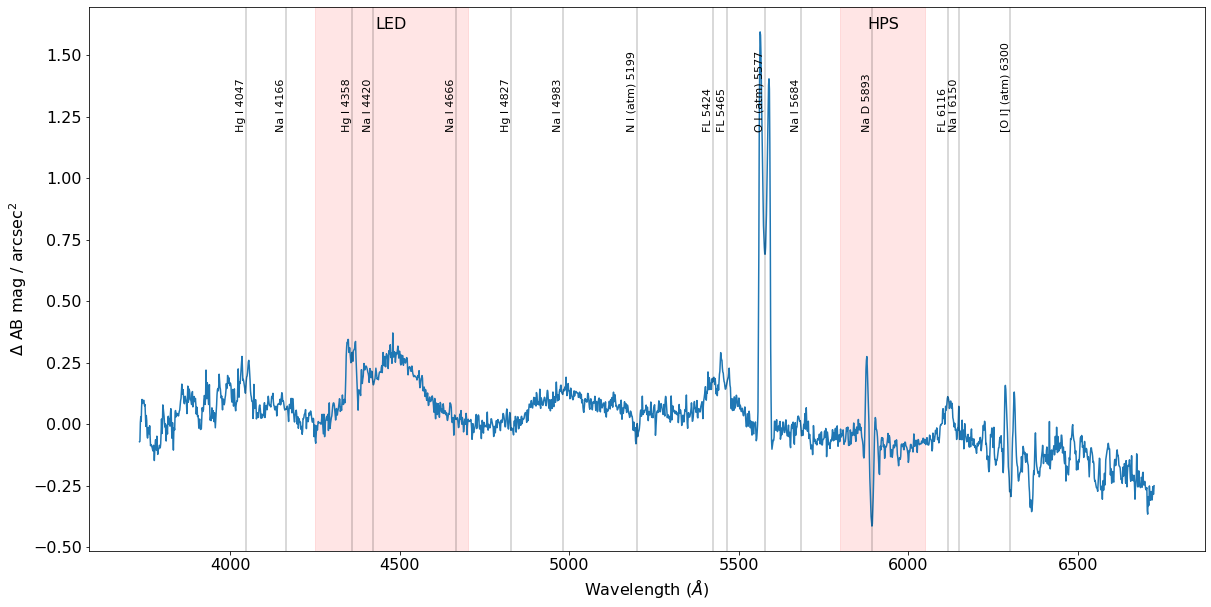

In [127]:
plt.rc('font', size=16)
plt.figure(figsize=[20,10])
diff = massey_smooth-zen_flux
plt.ylabel("AB mag / arcsec$^2$")
plt.plot(w, diff)
txt_y = diff.max()
for f in features:
    if f['low wave'] != f['high wave']:
        plt.axvspan(f['low wave'], f['high wave'], color='r', alpha=0.1)
        txt_x = 0.5*(f['low wave'] + f['high wave'])
        plt.text(txt_x, txt_y, f['name'], horizontalalignment='center', verticalalignment='bottom')
    else:
        x = f['low wave']
        plt.text(x, 0.75*txt_y, f"{f['name']} {x}", rotation='vertical', fontsize='x-small', horizontalalignment='right')
        plt.axvline(x, color='black', alpha=0.2)
plt.xlabel("Wavelength $(\AA)$")
plt.ylabel("$\Delta$ AB mag / arcsec$^2$")
plt.savefig("zenith_diff.pdf")
plt.show()

In [133]:
june_path = Path("20190607_ggw/pypeit/Science")
oct_path = Path("20191005/pypeit/Science")

oct_files = [
    "az90_el85",
    "az270_el85",
    "az37.6_el20",
    "az37.6_el45",
    "az67.5_el20",
    "az67.5_el45",
    "az352_el20",
    "az352_el45",
    "az186.6_el20",
    "az186.6_el45",
    "az186.6_el40",
    "az270_el20",
    "az270_el47",
    "az90_el20",
    "az90_el56"
]

june_files = [
    "az90_el85",
    "az37.6_el20",
    "az37.6_el45",
    "az67.5_el20",
    "az67.5_el45",
    "az352_el20",
    "az352_el45",
    "az186.6_el20",
    "az186.6_el45",
    "az180_el20",
    "az180_el40",
    "az90_el20",
    "az90_el56",
    "az0_el20",
    "az0_el42",
    "az270_el20",
    "az270_el47"
]

In [148]:
test_files = june_path.glob("spec1d*az90_el85*.fits")

In [175]:
def coadd_spectra(filelist):
    spectra = []
    for f in filelist:
        spectra.append(load_sky_spectrum(f))
    nspec = len(spectra)
    sp = spectra.pop(0)
    for s in spectra:
        sp = sp + s
    arr_sp = pysynphot.ArraySpectrum(sp.wave, sp.flux/nspec, fluxunits='flam')
    return arr_sp

In [176]:
test = coadd_spectra(june_path.glob("spec1d*az90_el85*.fits"))
test

In [177]:
june_spectra = {}
oct_spectra = {}
for loc in june_files:
    june_spectra[loc] = coadd_spectra(june_path.glob(f"spec1d*{loc}*.fits"))
    june_spectra[loc].convert('abmag')
for loc in oct_files:
    oct_spectra[loc] = coadd_spectra(oct_path.glob(f"spec1d*{loc}*.fits"))
    oct_spectra[loc].convert('abmag')

In [192]:
sorted(list(set(june_files).intersection(oct_files)))

['az186.6_el20',
 'az186.6_el45',
 'az270_el20',
 'az270_el47',
 'az352_el20',
 'az352_el45',
 'az37.6_el20',
 'az37.6_el45',
 'az67.5_el20',
 'az67.5_el45',
 'az90_el20',
 'az90_el56',
 'az90_el85']

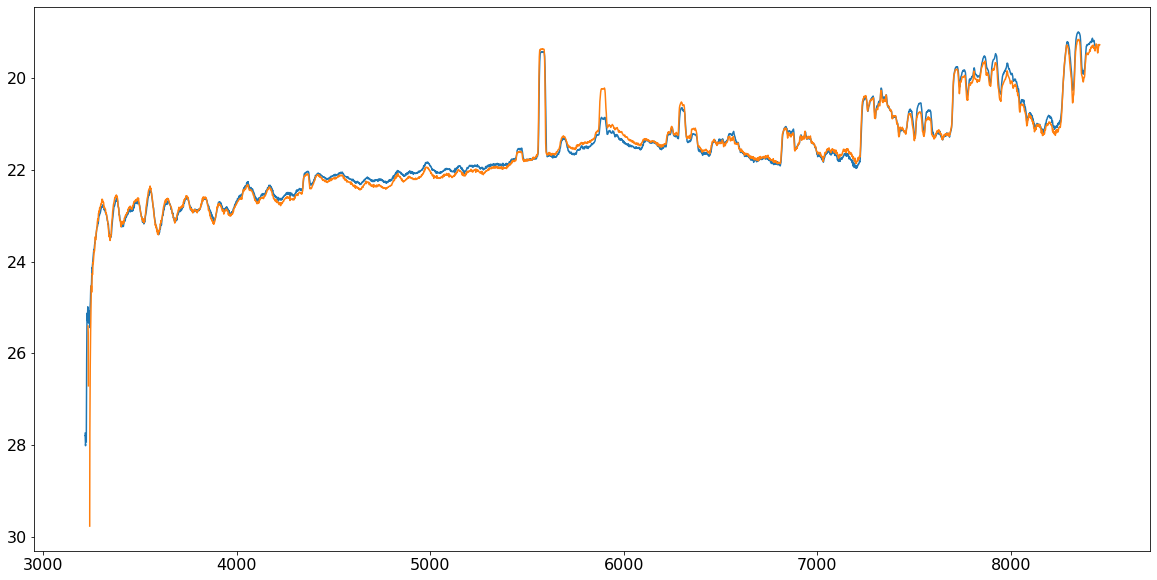

In [213]:
plt.figure(figsize=[20,10])
key = 'az90_el85'
plt.plot(june_spectra[key].wave, june_spectra[key].flux)
plt.plot(oct_spectra[key].wave, oct_spectra[key].flux)
plt.gca().invert_yaxis()
plt.show()